In [5]:
import os
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.postprocessing.regular.inverse_preprocesser import inverse_transform

model = WGAN_GP

2023-02-04 23:06:48.822504: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-04 23:06:48.822566: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Load the real data set which we use to create synthetic data

In [6]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.shape

(284807, 31)

In [7]:
num_cols = list(data.columns[ data.columns != 'Class' ])
cat_cols = ['Class']

sorted_cols = ['V14', 'V4', 'V10', 'V17', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

processed_data = data[ sorted_cols ].copy()

In [8]:
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of variables - {}".format(train_data.shape[0], train_data.shape[1]))

# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 492 rows ('labels') having values either 0 or 1 for the 2 clustered classes.
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ num_cols ])

# Get the count of both classes
print( pd.DataFrame( [ [sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of variables - 31
   count
0    281
1    211


In [9]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
(100*492)/284315

0.17304750013189596

## Step 2: Train the synthesizers and create the model

In [11]:
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 500+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

#Setting the GAN model parameters and the training step parameters
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [12]:
synthesizer = model(gan_args,  n_critic=2)
synthesizer.train(data = fraud_w_classes, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

2023-02-04 23:06:54.598892: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-04 23:06:54.599375: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-04 23:06:54.599401: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-04 23:06:54.599430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5b893a1e6742): /proc/driver/nvidia/version does not exist
2023-02-04 23:06:54.631471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the 

Epoch: 0 | disc_loss: 0.4177650213241577 | gen_loss: 0.010515214875340462
Epoch: 1 | disc_loss: -0.01479995995759964 | gen_loss: 0.017731867730617523


  1%|          | 5/501 [00:02<02:58,  2.77it/s]

Epoch: 2 | disc_loss: -0.06780305504798889 | gen_loss: 0.01121957041323185
Epoch: 3 | disc_loss: -0.061260249465703964 | gen_loss: 0.004822070244699717
Epoch: 4 | disc_loss: -0.06498324871063232 | gen_loss: 0.04286076873540878


  1%|▏         | 7/501 [00:02<02:02,  4.04it/s]

Epoch: 5 | disc_loss: -0.09540330618619919 | gen_loss: 0.024229630827903748
Epoch: 6 | disc_loss: -0.016781095415353775 | gen_loss: 0.0125022754073143
Epoch: 7 | disc_loss: 0.020968712866306305 | gen_loss: -0.030232900753617287


  2%|▏         | 11/501 [00:03<01:15,  6.50it/s]

Epoch: 8 | disc_loss: 0.039017196744680405 | gen_loss: 0.0077836774289608
Epoch: 9 | disc_loss: 0.042105838656425476 | gen_loss: 0.0024089612998068333
Epoch: 10 | disc_loss: -0.007279622368514538 | gen_loss: -0.009106110781431198


  3%|▎         | 13/501 [00:03<01:04,  7.51it/s]

Epoch: 11 | disc_loss: 0.21224184334278107 | gen_loss: 0.042253799736499786
Epoch: 12 | disc_loss: 0.005729079246520996 | gen_loss: -0.004376290366053581
Epoch: 13 | disc_loss: 0.017251521348953247 | gen_loss: -0.004167288541793823


  3%|▎         | 17/501 [00:03<00:53,  9.09it/s]

Epoch: 14 | disc_loss: -0.031369052827358246 | gen_loss: -0.0016581647796556354
Epoch: 15 | disc_loss: 0.005364794284105301 | gen_loss: 0.013834172859787941
Epoch: 16 | disc_loss: 0.20859338343143463 | gen_loss: -0.004557781852781773


  4%|▍         | 19/501 [00:03<00:50,  9.63it/s]

Epoch: 17 | disc_loss: -0.024506129324436188 | gen_loss: -0.02361312136054039
Epoch: 18 | disc_loss: 0.0632563978433609 | gen_loss: -0.017368867993354797
Epoch: 19 | disc_loss: -0.011713791638612747 | gen_loss: -0.011330654844641685


  5%|▍         | 23/501 [00:04<00:45, 10.46it/s]

Epoch: 20 | disc_loss: -0.02626197226345539 | gen_loss: -0.02190253883600235
Epoch: 21 | disc_loss: 0.11826872080564499 | gen_loss: -0.00318635581061244
Epoch: 22 | disc_loss: -0.022045696154236794 | gen_loss: -0.01638580858707428


  5%|▍         | 25/501 [00:04<00:45, 10.37it/s]

Epoch: 23 | disc_loss: -0.021678758785128593 | gen_loss: -0.02144661732017994
Epoch: 24 | disc_loss: 0.10877035558223724 | gen_loss: -0.011788666248321533
Epoch: 25 | disc_loss: 0.024300429970026016 | gen_loss: 0.029414042830467224


  6%|▌         | 29/501 [00:04<00:43, 10.77it/s]

Epoch: 26 | disc_loss: 0.0905352383852005 | gen_loss: 0.018570981919765472
Epoch: 27 | disc_loss: 0.06425167620182037 | gen_loss: -0.012677610851824284
Epoch: 28 | disc_loss: -0.008728688582777977 | gen_loss: -0.015122450888156891


  6%|▌         | 31/501 [00:04<00:43, 10.74it/s]

Epoch: 29 | disc_loss: -0.02581651136279106 | gen_loss: -0.00781085342168808
Epoch: 30 | disc_loss: 0.026113469153642654 | gen_loss: -0.011846113950014114
Epoch: 31 | disc_loss: 0.08979997783899307 | gen_loss: 0.016086949035525322


  7%|▋         | 35/501 [00:05<00:42, 10.92it/s]

Epoch: 32 | disc_loss: -0.004087250679731369 | gen_loss: -0.010581052862107754
Epoch: 33 | disc_loss: 0.06668409705162048 | gen_loss: -0.01631772890686989
Epoch: 34 | disc_loss: 0.08350951969623566 | gen_loss: 0.0026609180495142937


  7%|▋         | 37/501 [00:05<00:43, 10.75it/s]

Epoch: 35 | disc_loss: 0.09773845225572586 | gen_loss: 0.026537124067544937
Epoch: 36 | disc_loss: -0.013588052242994308 | gen_loss: 0.0019440233008936048


  8%|▊         | 39/501 [00:05<00:44, 10.32it/s]

Epoch: 37 | disc_loss: -0.015222120098769665 | gen_loss: -0.011500494554638863
Epoch: 38 | disc_loss: 0.002912808209657669 | gen_loss: 0.009483570232987404
Epoch: 39 | disc_loss: -0.012490993365645409 | gen_loss: -0.0007607148727402091


  9%|▊         | 43/501 [00:06<00:43, 10.59it/s]

Epoch: 40 | disc_loss: -0.01843455247581005 | gen_loss: -0.005822504870593548
Epoch: 41 | disc_loss: 0.040645625442266464 | gen_loss: 0.0009692762396298349
Epoch: 42 | disc_loss: 0.18260589241981506 | gen_loss: -0.0002789292484521866


  9%|▉         | 45/501 [00:06<00:42, 10.81it/s]

Epoch: 43 | disc_loss: 0.003993995487689972 | gen_loss: 0.024745604023337364
Epoch: 44 | disc_loss: -0.016792617738246918 | gen_loss: 0.0059046694077551365
Epoch: 45 | disc_loss: 0.03760072588920593 | gen_loss: -0.018465949222445488


 10%|▉         | 49/501 [00:06<00:40, 11.03it/s]

Epoch: 46 | disc_loss: 0.02219371870160103 | gen_loss: 0.0008497461676597595
Epoch: 47 | disc_loss: 0.003398783504962921 | gen_loss: 0.023737147450447083
Epoch: 48 | disc_loss: -0.02311246655881405 | gen_loss: -0.001145463204011321


 10%|█         | 51/501 [00:06<00:40, 11.01it/s]

Epoch: 49 | disc_loss: 0.021231988444924355 | gen_loss: 0.0069773574359714985
Epoch: 50 | disc_loss: -0.02323378250002861 | gen_loss: 0.016246341168880463
Epoch: 51 | disc_loss: -0.017755834385752678 | gen_loss: -0.029779057949781418


 11%|█         | 55/501 [00:07<00:39, 11.19it/s]

Epoch: 52 | disc_loss: -0.025576112791895866 | gen_loss: -0.006301362998783588
Epoch: 53 | disc_loss: 0.001949947327375412 | gen_loss: -0.006666473113000393
Epoch: 54 | disc_loss: -0.01287455391138792 | gen_loss: -0.006872860714793205


 11%|█▏        | 57/501 [00:07<00:39, 11.27it/s]

Epoch: 55 | disc_loss: 0.057509444653987885 | gen_loss: -0.010010374709963799
Epoch: 56 | disc_loss: -0.02354690060019493 | gen_loss: -0.031570784747600555


 12%|█▏        | 59/501 [00:07<00:43, 10.13it/s]

Epoch: 57 | disc_loss: 0.061986684799194336 | gen_loss: -0.03537255898118019
Epoch: 58 | disc_loss: -0.024371791630983353 | gen_loss: -0.028304224833846092
Epoch: 59 | disc_loss: -0.030284633859992027 | gen_loss: 0.018540382385253906


 13%|█▎        | 63/501 [00:07<00:41, 10.61it/s]

Epoch: 60 | disc_loss: -0.023832760751247406 | gen_loss: 0.009241992607712746
Epoch: 61 | disc_loss: -0.01491751428693533 | gen_loss: 0.007519128732383251
Epoch: 62 | disc_loss: 0.1384740173816681 | gen_loss: 0.020556552335619926


 13%|█▎        | 65/501 [00:08<00:41, 10.61it/s]

Epoch: 63 | disc_loss: 0.0980052500963211 | gen_loss: 0.006492468062788248
Epoch: 64 | disc_loss: -0.01308799535036087 | gen_loss: -0.005281850229948759
Epoch: 65 | disc_loss: -0.005557777360081673 | gen_loss: 0.019532307982444763


 14%|█▍        | 69/501 [00:08<00:40, 10.77it/s]

Epoch: 66 | disc_loss: 0.008880864828824997 | gen_loss: -0.00377749209292233
Epoch: 67 | disc_loss: -0.024868743494153023 | gen_loss: 0.02219000644981861
Epoch: 68 | disc_loss: -0.013021016493439674 | gen_loss: -0.03831763193011284


 14%|█▍        | 71/501 [00:08<00:40, 10.72it/s]

Epoch: 69 | disc_loss: 0.059647440910339355 | gen_loss: -0.03790031373500824
Epoch: 70 | disc_loss: -0.028793586418032646 | gen_loss: -0.0035439259372651577
Epoch: 71 | disc_loss: 0.19887377321720123 | gen_loss: -0.012676412239670753


 15%|█▍        | 75/501 [00:09<00:40, 10.59it/s]

Epoch: 72 | disc_loss: -0.029322868213057518 | gen_loss: -0.011605083011090755
Epoch: 73 | disc_loss: 0.026031769812107086 | gen_loss: -0.015697941184043884
Epoch: 74 | disc_loss: 0.03728456050157547 | gen_loss: -0.006047425791621208


 15%|█▌        | 77/501 [00:09<00:39, 10.68it/s]

Epoch: 75 | disc_loss: -0.013552454300224781 | gen_loss: -0.014128906652331352
Epoch: 76 | disc_loss: 0.11402285099029541 | gen_loss: 0.01422790251672268
Epoch: 77 | disc_loss: 0.022255901247262955 | gen_loss: 0.004395207855850458


 16%|█▌        | 81/501 [00:09<00:38, 10.84it/s]

Epoch: 78 | disc_loss: -0.027712630107998848 | gen_loss: -0.005403468385338783
Epoch: 79 | disc_loss: 0.010527342557907104 | gen_loss: -0.02894006296992302
Epoch: 80 | disc_loss: -0.01708027347922325 | gen_loss: 0.03141867369413376


 17%|█▋        | 83/501 [00:09<00:38, 10.97it/s]

Epoch: 81 | disc_loss: -0.028098274022340775 | gen_loss: 0.03775683790445328
Epoch: 82 | disc_loss: 0.013460392132401466 | gen_loss: 0.007470454089343548
Epoch: 83 | disc_loss: -0.002974238246679306 | gen_loss: -0.0019063812214881182


 17%|█▋        | 87/501 [00:10<00:37, 11.05it/s]

Epoch: 84 | disc_loss: 0.0549737811088562 | gen_loss: -0.021684110164642334
Epoch: 85 | disc_loss: 0.05520540103316307 | gen_loss: -0.014779409393668175
Epoch: 86 | disc_loss: -0.00978668313473463 | gen_loss: -0.02107883244752884


 18%|█▊        | 89/501 [00:10<00:37, 11.05it/s]

Epoch: 87 | disc_loss: 0.30783167481422424 | gen_loss: 0.005549489986151457
Epoch: 88 | disc_loss: -0.002617496997117996 | gen_loss: -0.0009196200408041477
Epoch: 89 | disc_loss: -0.02977784536778927 | gen_loss: -0.00569135183468461


 19%|█▊        | 93/501 [00:10<00:36, 11.11it/s]

Epoch: 90 | disc_loss: 0.10643625259399414 | gen_loss: -0.013091299682855606
Epoch: 91 | disc_loss: 0.16600154340267181 | gen_loss: -0.00700136786326766
Epoch: 92 | disc_loss: -0.010060354135930538 | gen_loss: -0.023618334904313087


 19%|█▉        | 95/501 [00:10<00:36, 11.27it/s]

Epoch: 93 | disc_loss: -0.014549861662089825 | gen_loss: -0.018634764477610588
Epoch: 94 | disc_loss: -0.012673115357756615 | gen_loss: -0.05159830302000046
Epoch: 95 | disc_loss: -0.029001228511333466 | gen_loss: -0.026100613176822662


 20%|█▉        | 99/501 [00:11<00:35, 11.37it/s]

Epoch: 96 | disc_loss: -0.010587623342871666 | gen_loss: -0.007465159520506859
Epoch: 97 | disc_loss: -0.021084332838654518 | gen_loss: 0.06759187579154968
Epoch: 98 | disc_loss: -0.026742879301309586 | gen_loss: 0.04150215536355972


 20%|██        | 101/501 [00:11<00:36, 11.04it/s]

Epoch: 99 | disc_loss: 0.012428883463144302 | gen_loss: 0.03054465353488922
Epoch: 100 | disc_loss: -0.0006505027413368225 | gen_loss: 0.03511079400777817


 21%|██        | 103/501 [00:11<00:36, 10.89it/s]

Epoch: 101 | disc_loss: -0.028455037623643875 | gen_loss: 0.01934584602713585
Epoch: 102 | disc_loss: -0.029143501073122025 | gen_loss: 0.013806141912937164
Epoch: 103 | disc_loss: -0.015529823489487171 | gen_loss: 0.06704451888799667


 21%|██▏       | 107/501 [00:11<00:35, 11.21it/s]

Epoch: 104 | disc_loss: 0.5385937690734863 | gen_loss: 0.0294929388910532
Epoch: 105 | disc_loss: -0.009355543181300163 | gen_loss: 0.047749459743499756
Epoch: 106 | disc_loss: 0.009454762563109398 | gen_loss: 0.028030503541231155


 22%|██▏       | 109/501 [00:12<00:34, 11.26it/s]

Epoch: 107 | disc_loss: 0.01812812127172947 | gen_loss: 0.020267466083168983
Epoch: 108 | disc_loss: 0.0001239050179719925 | gen_loss: 0.04814016446471214
Epoch: 109 | disc_loss: 0.1949205994606018 | gen_loss: 0.06675899028778076


 23%|██▎       | 113/501 [00:12<00:34, 11.23it/s]

Epoch: 110 | disc_loss: 0.012425828725099564 | gen_loss: 0.04300994426012039
Epoch: 111 | disc_loss: -0.00042340531945228577 | gen_loss: 0.04832644760608673
Epoch: 112 | disc_loss: -0.025128522887825966 | gen_loss: 0.05429909750819206


 23%|██▎       | 115/501 [00:12<00:34, 11.15it/s]

Epoch: 113 | disc_loss: -0.028552651405334473 | gen_loss: 0.03892891854047775
Epoch: 114 | disc_loss: -0.004123236984014511 | gen_loss: 0.062464483082294464
Epoch: 115 | disc_loss: 0.02937162294983864 | gen_loss: 0.020497528836131096


 24%|██▍       | 119/501 [00:13<00:35, 10.78it/s]

Epoch: 116 | disc_loss: -0.02618427947163582 | gen_loss: 0.006144966930150986
Epoch: 117 | disc_loss: 0.026115622371435165 | gen_loss: 0.02787144109606743
Epoch: 118 | disc_loss: -0.000624045729637146 | gen_loss: 0.05213915929198265


 24%|██▍       | 121/501 [00:13<00:35, 10.67it/s]

Epoch: 119 | disc_loss: 0.09277454018592834 | gen_loss: 0.1443423181772232
Epoch: 120 | disc_loss: 0.018401462584733963 | gen_loss: 0.010173855349421501
Epoch: 121 | disc_loss: 0.024135995656251907 | gen_loss: -0.007892628200352192


 25%|██▍       | 125/501 [00:13<00:34, 10.98it/s]

Epoch: 122 | disc_loss: 0.019961707293987274 | gen_loss: -0.005740982946008444
Epoch: 123 | disc_loss: -0.03183629363775253 | gen_loss: -0.010073043406009674
Epoch: 124 | disc_loss: -0.025402719154953957 | gen_loss: -0.036085277795791626


 25%|██▌       | 127/501 [00:13<00:34, 10.94it/s]

Epoch: 125 | disc_loss: 0.44926223158836365 | gen_loss: -0.03531975299119949
Epoch: 126 | disc_loss: -0.011514099314808846 | gen_loss: -0.09654240310192108
Epoch: 127 | disc_loss: -0.01865888200700283 | gen_loss: -0.04029078781604767


 26%|██▌       | 131/501 [00:14<00:33, 11.04it/s]

Epoch: 128 | disc_loss: -0.03383617848157883 | gen_loss: -0.0403866320848465
Epoch: 129 | disc_loss: 0.006191404536366463 | gen_loss: -0.14141550660133362
Epoch: 130 | disc_loss: 0.0033345557749271393 | gen_loss: -0.05743875354528427


 27%|██▋       | 133/501 [00:14<00:33, 11.13it/s]

Epoch: 131 | disc_loss: -0.020424222573637962 | gen_loss: -0.03843427449464798
Epoch: 132 | disc_loss: -0.028636544942855835 | gen_loss: -0.05198138952255249
Epoch: 133 | disc_loss: -0.03287959471344948 | gen_loss: -0.031040111556649208


 27%|██▋       | 137/501 [00:14<00:32, 11.04it/s]

Epoch: 134 | disc_loss: 0.13031946122646332 | gen_loss: -0.17386025190353394
Epoch: 135 | disc_loss: 0.06464404612779617 | gen_loss: -0.10705530643463135
Epoch: 136 | disc_loss: 0.02529408410191536 | gen_loss: -0.10631392151117325


 28%|██▊       | 139/501 [00:14<00:32, 11.02it/s]

Epoch: 137 | disc_loss: -0.0027791596949100494 | gen_loss: -0.07050784677267075
Epoch: 138 | disc_loss: -0.03011137805879116 | gen_loss: -0.050343044102191925
Epoch: 139 | disc_loss: 0.0616622194647789 | gen_loss: -0.11447828263044357


 28%|██▊       | 141/501 [00:15<00:32, 11.00it/s]

Epoch: 140 | disc_loss: -0.02680700458586216 | gen_loss: -0.09304510802030563
Epoch: 141 | disc_loss: -0.01415984146296978 | gen_loss: -0.07641634345054626


 29%|██▊       | 143/501 [00:15<00:34, 10.50it/s]

Epoch: 142 | disc_loss: 0.03493887931108475 | gen_loss: -0.08611899614334106
Epoch: 143 | disc_loss: 0.14230674505233765 | gen_loss: -0.07785692811012268


 29%|██▉       | 146/501 [00:15<00:37,  9.44it/s]

Epoch: 144 | disc_loss: 0.05251964181661606 | gen_loss: 0.011258639395236969
Epoch: 145 | disc_loss: 0.023836547508835793 | gen_loss: -0.03326737880706787


 30%|██▉       | 148/501 [00:15<00:40,  8.63it/s]

Epoch: 146 | disc_loss: 0.039472535252571106 | gen_loss: -0.03984227031469345
Epoch: 147 | disc_loss: -0.03087012469768524 | gen_loss: -0.03547509014606476


 30%|██▉       | 150/501 [00:16<00:40,  8.57it/s]

Epoch: 148 | disc_loss: 0.03686177358031273 | gen_loss: -0.050774797797203064
Epoch: 149 | disc_loss: 0.09934906661510468 | gen_loss: -0.053730908781290054


 30%|███       | 152/501 [00:16<00:40,  8.65it/s]

Epoch: 150 | disc_loss: -0.011311696842312813 | gen_loss: -0.06312933564186096
Epoch: 151 | disc_loss: -0.014810120686888695 | gen_loss: -0.05970661714673042


 31%|███       | 154/501 [00:16<00:46,  7.49it/s]

Epoch: 152 | disc_loss: 0.029107440263032913 | gen_loss: -0.056793153285980225
Epoch: 153 | disc_loss: -0.012530249543488026 | gen_loss: -0.05756613612174988


 31%|███▏      | 157/501 [00:16<00:38,  9.03it/s]

Epoch: 154 | disc_loss: 0.059749092906713486 | gen_loss: -0.05501048266887665
Epoch: 155 | disc_loss: -0.02711380086839199 | gen_loss: -0.037295110523700714
Epoch: 156 | disc_loss: -0.024587061256170273 | gen_loss: -0.034169163554906845


 32%|███▏      | 159/501 [00:17<00:35,  9.63it/s]

Epoch: 157 | disc_loss: -0.02271566167473793 | gen_loss: -0.11813483387231827
Epoch: 158 | disc_loss: 0.014978069812059402 | gen_loss: -0.07295358926057816
Epoch: 159 | disc_loss: -0.03421306237578392 | gen_loss: -0.06272313743829727


 33%|███▎      | 163/501 [00:17<00:32, 10.46it/s]

Epoch: 160 | disc_loss: -0.0010428279638290405 | gen_loss: -0.06803188472986221
Epoch: 161 | disc_loss: 0.031048785895109177 | gen_loss: -0.052019327878952026
Epoch: 162 | disc_loss: -0.022858936339616776 | gen_loss: -0.06154557317495346


 33%|███▎      | 165/501 [00:17<00:31, 10.79it/s]

Epoch: 163 | disc_loss: 0.03842944651842117 | gen_loss: -0.0673820823431015
Epoch: 164 | disc_loss: -0.029282448813319206 | gen_loss: -0.037279680371284485
Epoch: 165 | disc_loss: -0.029817884787917137 | gen_loss: -0.05498553439974785


 34%|███▎      | 169/501 [00:18<00:30, 10.83it/s]

Epoch: 166 | disc_loss: 0.08002187311649323 | gen_loss: -0.008954726159572601
Epoch: 167 | disc_loss: -0.016658252105116844 | gen_loss: -0.05170057713985443
Epoch: 168 | disc_loss: 0.1385553777217865 | gen_loss: -0.05455943942070007


 34%|███▍      | 171/501 [00:18<00:30, 10.91it/s]

Epoch: 169 | disc_loss: -0.033195558935403824 | gen_loss: -0.03041381761431694
Epoch: 170 | disc_loss: 0.027589496225118637 | gen_loss: -0.020246388390660286
Epoch: 171 | disc_loss: 0.024883180856704712 | gen_loss: -0.027587438002228737


 35%|███▍      | 175/501 [00:18<00:29, 11.06it/s]

Epoch: 172 | disc_loss: 0.016820285469293594 | gen_loss: -0.03136803209781647
Epoch: 173 | disc_loss: 0.05784974619746208 | gen_loss: 0.011196990497410297
Epoch: 174 | disc_loss: 0.013033594936132431 | gen_loss: 0.04678560793399811


 35%|███▌      | 177/501 [00:18<00:29, 11.03it/s]

Epoch: 175 | disc_loss: 0.017242591828107834 | gen_loss: -0.01806863583624363
Epoch: 176 | disc_loss: 0.04538043588399887 | gen_loss: -0.08761028200387955
Epoch: 177 | disc_loss: -0.007422855123877525 | gen_loss: -0.06538516283035278


 36%|███▌      | 181/501 [00:19<00:28, 11.04it/s]

Epoch: 178 | disc_loss: 0.21329069137573242 | gen_loss: -0.01467110775411129
Epoch: 179 | disc_loss: -0.013413469307124615 | gen_loss: -0.05566524714231491
Epoch: 180 | disc_loss: -0.008498433977365494 | gen_loss: -0.0727514997124672


 37%|███▋      | 183/501 [00:19<00:28, 10.97it/s]

Epoch: 181 | disc_loss: -0.023109138011932373 | gen_loss: -0.04960356652736664
Epoch: 182 | disc_loss: -0.0019300170242786407 | gen_loss: -0.0354142002761364
Epoch: 183 | disc_loss: -0.021713292226195335 | gen_loss: -0.043342381715774536


 37%|███▋      | 187/501 [00:19<00:28, 11.00it/s]

Epoch: 184 | disc_loss: 0.07356467097997665 | gen_loss: -0.0851207822561264
Epoch: 185 | disc_loss: 0.06925740838050842 | gen_loss: -0.14670877158641815
Epoch: 186 | disc_loss: -0.021286245435476303 | gen_loss: 0.015940628945827484


 38%|███▊      | 189/501 [00:19<00:28, 10.88it/s]

Epoch: 187 | disc_loss: -0.007100781425833702 | gen_loss: -0.08191457390785217
Epoch: 188 | disc_loss: -0.023339709267020226 | gen_loss: -0.07976418733596802
Epoch: 189 | disc_loss: 0.02835214138031006 | gen_loss: -0.07138032466173172


 39%|███▊      | 193/501 [00:20<00:27, 11.05it/s]

Epoch: 190 | disc_loss: 0.026109378784894943 | gen_loss: -0.05408473685383797
Epoch: 191 | disc_loss: -0.025296993553638458 | gen_loss: -0.08504290133714676
Epoch: 192 | disc_loss: 0.04043280705809593 | gen_loss: -0.020194828510284424


 39%|███▉      | 195/501 [00:20<00:27, 11.03it/s]

Epoch: 193 | disc_loss: -0.012376902624964714 | gen_loss: -0.10664154589176178
Epoch: 194 | disc_loss: -0.005255797877907753 | gen_loss: -0.08683976531028748
Epoch: 195 | disc_loss: -0.011654173955321312 | gen_loss: -0.09964153170585632


 40%|███▉      | 199/501 [00:20<00:27, 11.03it/s]

Epoch: 196 | disc_loss: -0.024893807247281075 | gen_loss: -0.06496316194534302
Epoch: 197 | disc_loss: -0.010208822786808014 | gen_loss: -0.04214852303266525
Epoch: 198 | disc_loss: -0.022385992109775543 | gen_loss: -0.06253191828727722


 40%|████      | 201/501 [00:20<00:27, 10.74it/s]

Epoch: 199 | disc_loss: -0.02374456822872162 | gen_loss: -0.031581126153469086
Epoch: 200 | disc_loss: 0.3816637098789215 | gen_loss: -0.010311414487659931
Epoch: 201 | disc_loss: -0.005117589142173529 | gen_loss: 0.016040068119764328


 41%|████      | 205/501 [00:21<00:26, 11.08it/s]

Epoch: 202 | disc_loss: -0.022130586206912994 | gen_loss: 0.018144870176911354
Epoch: 203 | disc_loss: 0.2226044088602066 | gen_loss: -0.04927556589245796
Epoch: 204 | disc_loss: 0.013161972165107727 | gen_loss: -0.017991937696933746


 41%|████▏     | 207/501 [00:21<00:26, 11.04it/s]

Epoch: 205 | disc_loss: -0.024440310895442963 | gen_loss: -0.014402670785784721
Epoch: 206 | disc_loss: -0.016482632607221603 | gen_loss: -0.03491061180830002
Epoch: 207 | disc_loss: -0.02649141661822796 | gen_loss: 0.0036126556806266308


 42%|████▏     | 211/501 [00:21<00:26, 11.15it/s]

Epoch: 208 | disc_loss: -0.020085439085960388 | gen_loss: -0.01713452860713005
Epoch: 209 | disc_loss: 0.10770487040281296 | gen_loss: -0.024276312440633774
Epoch: 210 | disc_loss: 0.03591282293200493 | gen_loss: -0.02311295084655285


 43%|████▎     | 213/501 [00:22<00:26, 10.99it/s]

Epoch: 211 | disc_loss: -0.020261112600564957 | gen_loss: 0.03968439996242523
Epoch: 212 | disc_loss: -0.01259247399866581 | gen_loss: 0.010003234259784222
Epoch: 213 | disc_loss: -0.02944657951593399 | gen_loss: 0.021557794883847237


 43%|████▎     | 217/501 [00:22<00:26, 10.80it/s]

Epoch: 214 | disc_loss: 0.12973132729530334 | gen_loss: -0.03584934398531914
Epoch: 215 | disc_loss: -0.028178079053759575 | gen_loss: -0.021130776032805443
Epoch: 216 | disc_loss: -0.017759140580892563 | gen_loss: 0.003024121280759573


 44%|████▎     | 219/501 [00:22<00:25, 10.87it/s]

Epoch: 217 | disc_loss: 0.019532982259988785 | gen_loss: -0.02230251207947731
Epoch: 218 | disc_loss: -0.02929037995636463 | gen_loss: -0.0009963540360331535
Epoch: 219 | disc_loss: -0.021965865045785904 | gen_loss: -0.002557456959038973


 45%|████▍     | 223/501 [00:22<00:25, 10.79it/s]

Epoch: 220 | disc_loss: -0.014221232384443283 | gen_loss: 0.007296058349311352
Epoch: 221 | disc_loss: 0.018389753997325897 | gen_loss: -0.0005738522158935666
Epoch: 222 | disc_loss: -0.029791483655571938 | gen_loss: 0.014174913056194782


 45%|████▍     | 225/501 [00:23<00:25, 10.79it/s]

Epoch: 223 | disc_loss: 0.0001621730625629425 | gen_loss: 0.04435839504003525
Epoch: 224 | disc_loss: 0.03238167613744736 | gen_loss: 0.03181469440460205
Epoch: 225 | disc_loss: 0.08020497858524323 | gen_loss: 0.05784075707197189


 46%|████▌     | 229/501 [00:23<00:24, 11.05it/s]

Epoch: 226 | disc_loss: -0.008753897622227669 | gen_loss: 0.033283211290836334
Epoch: 227 | disc_loss: -0.028256215155124664 | gen_loss: 0.006168951280415058
Epoch: 228 | disc_loss: -0.027199752628803253 | gen_loss: -0.02527168206870556


 46%|████▌     | 231/501 [00:23<00:24, 10.94it/s]

Epoch: 229 | disc_loss: 0.014327175915241241 | gen_loss: -0.027632039040327072
Epoch: 230 | disc_loss: -0.02516677789390087 | gen_loss: -0.0030174977146089077
Epoch: 231 | disc_loss: -0.0004048943519592285 | gen_loss: -0.041962575167417526


 47%|████▋     | 235/501 [00:24<00:24, 11.05it/s]

Epoch: 232 | disc_loss: -0.034687064588069916 | gen_loss: -0.031450942158699036
Epoch: 233 | disc_loss: 0.0636351928114891 | gen_loss: 0.005818155128508806
Epoch: 234 | disc_loss: 0.049787022173404694 | gen_loss: -0.05226833373308182


 47%|████▋     | 237/501 [00:24<00:24, 10.97it/s]

Epoch: 235 | disc_loss: -0.03240542113780975 | gen_loss: 0.0015228793490678072
Epoch: 236 | disc_loss: 0.04425425082445145 | gen_loss: -0.0055531095713377
Epoch: 237 | disc_loss: -0.02540283091366291 | gen_loss: 0.03538469597697258


 48%|████▊     | 241/501 [00:24<00:23, 11.02it/s]

Epoch: 238 | disc_loss: -0.010128680616617203 | gen_loss: 0.04104582965373993
Epoch: 239 | disc_loss: 0.14128869771957397 | gen_loss: 0.008006677962839603
Epoch: 240 | disc_loss: 0.05550224334001541 | gen_loss: -0.010169179178774357


 49%|████▊     | 243/501 [00:24<00:23, 10.91it/s]

Epoch: 241 | disc_loss: -0.024269651621580124 | gen_loss: -0.010873902589082718
Epoch: 242 | disc_loss: -0.027762698009610176 | gen_loss: 0.0009901397861540318
Epoch: 243 | disc_loss: 0.12875667214393616 | gen_loss: -0.0019225438591092825


 49%|████▉     | 247/501 [00:25<00:23, 11.04it/s]

Epoch: 244 | disc_loss: -0.008669913746416569 | gen_loss: 0.07923354208469391
Epoch: 245 | disc_loss: -0.006009295582771301 | gen_loss: 0.08566541969776154
Epoch: 246 | disc_loss: 0.07515032589435577 | gen_loss: 0.05789117142558098


 50%|████▉     | 249/501 [00:25<00:23, 10.95it/s]

Epoch: 247 | disc_loss: -0.01980167254805565 | gen_loss: 0.0631340891122818
Epoch: 248 | disc_loss: -0.02622869238257408 | gen_loss: 0.06632591038942337
Epoch: 249 | disc_loss: -0.02451230026781559 | gen_loss: 0.04493018984794617


 50%|█████     | 253/501 [00:25<00:22, 11.08it/s]

Epoch: 250 | disc_loss: 0.02330315299332142 | gen_loss: 0.022238966077566147
Epoch: 251 | disc_loss: 0.003261277452111244 | gen_loss: 0.01657280884683132
Epoch: 252 | disc_loss: -0.024985525757074356 | gen_loss: -0.024276521056890488


 51%|█████     | 255/501 [00:25<00:22, 11.12it/s]

Epoch: 253 | disc_loss: -0.011449291370809078 | gen_loss: 0.0600598081946373
Epoch: 254 | disc_loss: -0.0299348346889019 | gen_loss: 0.022677738219499588
Epoch: 255 | disc_loss: -0.026857951655983925 | gen_loss: 0.022927993908524513


 52%|█████▏    | 259/501 [00:26<00:22, 10.99it/s]

Epoch: 256 | disc_loss: 0.019854102283716202 | gen_loss: 0.012262188829481602
Epoch: 257 | disc_loss: -0.012940920889377594 | gen_loss: -0.007269078399986029
Epoch: 258 | disc_loss: 0.021620141342282295 | gen_loss: -0.013698499649763107


 52%|█████▏    | 261/501 [00:26<00:21, 11.17it/s]

Epoch: 259 | disc_loss: -0.02651348151266575 | gen_loss: -0.009617844596505165
Epoch: 260 | disc_loss: -0.024920638650655746 | gen_loss: -0.004046986345201731
Epoch: 261 | disc_loss: 0.009412195533514023 | gen_loss: -0.02884697914123535


 53%|█████▎    | 265/501 [00:26<00:21, 10.97it/s]

Epoch: 262 | disc_loss: -0.004276009276509285 | gen_loss: 0.05899707227945328
Epoch: 263 | disc_loss: -0.011878755874931812 | gen_loss: 0.024989642202854156
Epoch: 264 | disc_loss: 0.02284260466694832 | gen_loss: 0.018682297319173813


 53%|█████▎    | 267/501 [00:26<00:21, 10.95it/s]

Epoch: 265 | disc_loss: -0.023594051599502563 | gen_loss: 0.019227731972932816
Epoch: 266 | disc_loss: 0.004009488970041275 | gen_loss: 0.02975882589817047
Epoch: 267 | disc_loss: -0.02235918492078781 | gen_loss: 0.020838666707277298


 54%|█████▍    | 271/501 [00:27<00:20, 11.10it/s]

Epoch: 268 | disc_loss: -0.027065221220254898 | gen_loss: 0.010295776650309563
Epoch: 269 | disc_loss: 0.002244913950562477 | gen_loss: -0.003431807504966855
Epoch: 270 | disc_loss: -0.03070208989083767 | gen_loss: -0.0010021798079833388


 54%|█████▍    | 273/501 [00:27<00:20, 11.03it/s]

Epoch: 271 | disc_loss: -0.016047466546297073 | gen_loss: -0.030745431780815125
Epoch: 272 | disc_loss: 0.04530521482229233 | gen_loss: -0.015341958031058311


 55%|█████▍    | 275/501 [00:27<00:22, 10.14it/s]

Epoch: 273 | disc_loss: -0.014266034588217735 | gen_loss: -0.020533408969640732
Epoch: 274 | disc_loss: 0.015299085527658463 | gen_loss: -0.014444972388446331
Epoch: 275 | disc_loss: -0.024449683725833893 | gen_loss: -0.020475581288337708


 56%|█████▌    | 279/501 [00:28<00:21, 10.57it/s]

Epoch: 276 | disc_loss: 0.09769327938556671 | gen_loss: -0.004858193453401327
Epoch: 277 | disc_loss: 0.027946650981903076 | gen_loss: -0.01721392199397087
Epoch: 278 | disc_loss: -0.01660022884607315 | gen_loss: -0.005301429890096188


 56%|█████▌    | 281/501 [00:28<00:20, 10.65it/s]

Epoch: 279 | disc_loss: -0.012636050581932068 | gen_loss: 0.0020754016004502773
Epoch: 280 | disc_loss: 0.01476021483540535 | gen_loss: 0.04037119448184967
Epoch: 281 | disc_loss: 0.0535200871527195 | gen_loss: 0.015735920518636703


 57%|█████▋    | 285/501 [00:28<00:19, 10.92it/s]

Epoch: 282 | disc_loss: 0.01711074635386467 | gen_loss: 0.010639345273375511
Epoch: 283 | disc_loss: 0.032541707158088684 | gen_loss: -0.011718411929905415
Epoch: 284 | disc_loss: 0.01807517558336258 | gen_loss: -0.022130459547042847


 57%|█████▋    | 287/501 [00:28<00:19, 10.88it/s]

Epoch: 285 | disc_loss: -0.03330725058913231 | gen_loss: 0.020471788942813873
Epoch: 286 | disc_loss: -0.02672644890844822 | gen_loss: 0.0021836194209754467
Epoch: 287 | disc_loss: -0.01788242906332016 | gen_loss: 0.014205768704414368


 58%|█████▊    | 291/501 [00:29<00:19, 10.93it/s]

Epoch: 288 | disc_loss: -0.026535630226135254 | gen_loss: 0.01340947113931179
Epoch: 289 | disc_loss: 0.10604334622621536 | gen_loss: 0.036912951618433
Epoch: 290 | disc_loss: -0.00377010740339756 | gen_loss: 0.04538589343428612


 58%|█████▊    | 293/501 [00:29<00:18, 10.97it/s]

Epoch: 291 | disc_loss: -0.027341313660144806 | gen_loss: 0.061365757137537
Epoch: 292 | disc_loss: -0.01141006126999855 | gen_loss: 0.02182709239423275
Epoch: 293 | disc_loss: 0.034433964639902115 | gen_loss: 0.014124029316008091


 59%|█████▉    | 297/501 [00:29<00:18, 11.20it/s]

Epoch: 294 | disc_loss: -0.013406435027718544 | gen_loss: -0.014646381139755249
Epoch: 295 | disc_loss: -0.007232455536723137 | gen_loss: -0.024683400988578796
Epoch: 296 | disc_loss: -0.02850501611828804 | gen_loss: -0.014192543923854828


 60%|█████▉    | 299/501 [00:29<00:17, 11.29it/s]

Epoch: 297 | disc_loss: -0.012976556085050106 | gen_loss: -0.0014903845731168985
Epoch: 298 | disc_loss: -0.022848771885037422 | gen_loss: -0.015605669468641281
Epoch: 299 | disc_loss: -0.02326008677482605 | gen_loss: -0.005936195608228445


 60%|██████    | 301/501 [00:30<00:18, 10.92it/s]

Epoch: 300 | disc_loss: 0.036995481699705124 | gen_loss: -0.003509892150759697
Epoch: 301 | disc_loss: -0.026577439159154892 | gen_loss: -0.005211226642131805


 61%|██████    | 305/501 [00:30<00:17, 11.14it/s]

Epoch: 302 | disc_loss: 0.05342225730419159 | gen_loss: -0.0023532595951110125
Epoch: 303 | disc_loss: -0.02809271216392517 | gen_loss: -0.00515139102935791
Epoch: 304 | disc_loss: -0.02071758359670639 | gen_loss: -0.014515715651214123


 61%|██████▏   | 307/501 [00:30<00:17, 11.27it/s]

Epoch: 305 | disc_loss: 0.006336182355880737 | gen_loss: -0.03763493150472641
Epoch: 306 | disc_loss: -0.0023726187646389008 | gen_loss: -0.030507247895002365
Epoch: 307 | disc_loss: 0.02168719470500946 | gen_loss: -0.017416417598724365


 62%|██████▏   | 311/501 [00:30<00:16, 11.25it/s]

Epoch: 308 | disc_loss: 0.027883071452379227 | gen_loss: -0.028216801583766937
Epoch: 309 | disc_loss: 0.006704216822981834 | gen_loss: -0.011054541915655136
Epoch: 310 | disc_loss: 0.08435157686471939 | gen_loss: -0.01815088465809822


 62%|██████▏   | 313/501 [00:31<00:16, 11.28it/s]

Epoch: 311 | disc_loss: -0.010611386969685555 | gen_loss: -0.010789101012051105
Epoch: 312 | disc_loss: 0.02765296772122383 | gen_loss: -0.009942511096596718
Epoch: 313 | disc_loss: 0.11511457711458206 | gen_loss: -0.00877770222723484


 63%|██████▎   | 317/501 [00:31<00:16, 11.01it/s]

Epoch: 314 | disc_loss: -0.03262971714138985 | gen_loss: -0.018546979874372482
Epoch: 315 | disc_loss: 0.002941517159342766 | gen_loss: 0.009758549742400646
Epoch: 316 | disc_loss: 0.0021900199353694916 | gen_loss: -0.0051289694383740425


 64%|██████▎   | 319/501 [00:31<00:16, 10.97it/s]

Epoch: 317 | disc_loss: -0.00046741217374801636 | gen_loss: 0.009608367457985878
Epoch: 318 | disc_loss: -0.02663489058613777 | gen_loss: 0.01709582656621933
Epoch: 319 | disc_loss: 0.14061647653579712 | gen_loss: 0.03594936430454254


 64%|██████▍   | 323/501 [00:32<00:16, 10.88it/s]

Epoch: 320 | disc_loss: -0.0049184393137693405 | gen_loss: 0.04401770979166031
Epoch: 321 | disc_loss: 0.026911620050668716 | gen_loss: 0.06363414227962494
Epoch: 322 | disc_loss: -0.015072796493768692 | gen_loss: 0.032702960073947906


 65%|██████▍   | 325/501 [00:32<00:16, 10.83it/s]

Epoch: 323 | disc_loss: -0.02649921178817749 | gen_loss: 0.030361905694007874
Epoch: 324 | disc_loss: -0.02975589781999588 | gen_loss: 0.02372055873274803
Epoch: 325 | disc_loss: -0.004730241373181343 | gen_loss: 0.042496174573898315


 66%|██████▌   | 329/501 [00:32<00:15, 10.82it/s]

Epoch: 326 | disc_loss: -0.026571253314614296 | gen_loss: 0.03707006573677063
Epoch: 327 | disc_loss: -0.029070783406496048 | gen_loss: 0.03975953906774521
Epoch: 328 | disc_loss: -0.011501375585794449 | gen_loss: 0.04781857132911682


 66%|██████▌   | 331/501 [00:32<00:15, 10.83it/s]

Epoch: 329 | disc_loss: -0.030968567356467247 | gen_loss: 0.015034484677016735
Epoch: 330 | disc_loss: 0.025554249063134193 | gen_loss: 0.008708185516297817
Epoch: 331 | disc_loss: -0.020348280668258667 | gen_loss: 0.012699255719780922


 67%|██████▋   | 335/501 [00:33<00:15, 11.02it/s]

Epoch: 332 | disc_loss: 0.2077554315328598 | gen_loss: 0.0063500055111944675
Epoch: 333 | disc_loss: -0.026768499985337257 | gen_loss: -0.013858367688953876
Epoch: 334 | disc_loss: -0.0022917483001947403 | gen_loss: -0.008042199537158012


 67%|██████▋   | 337/501 [00:33<00:14, 11.02it/s]

Epoch: 335 | disc_loss: 0.005247004330158234 | gen_loss: 0.00988781824707985
Epoch: 336 | disc_loss: -0.025399398058652878 | gen_loss: 0.0230613611638546
Epoch: 337 | disc_loss: -0.012950120493769646 | gen_loss: -0.024649428203701973


 68%|██████▊   | 341/501 [00:33<00:14, 11.22it/s]

Epoch: 338 | disc_loss: 0.029381968080997467 | gen_loss: -0.00841408409178257
Epoch: 339 | disc_loss: -0.02985605038702488 | gen_loss: -0.005334054119884968
Epoch: 340 | disc_loss: 0.060909152030944824 | gen_loss: -0.008612246252596378


 68%|██████▊   | 343/501 [00:33<00:14, 11.26it/s]

Epoch: 341 | disc_loss: 0.04131137579679489 | gen_loss: -0.007750426884740591
Epoch: 342 | disc_loss: 0.0011252090334892273 | gen_loss: -0.028113774955272675
Epoch: 343 | disc_loss: 0.02093825861811638 | gen_loss: -0.018674127757549286


 69%|██████▉   | 347/501 [00:34<00:13, 11.25it/s]

Epoch: 344 | disc_loss: -0.02835441380739212 | gen_loss: 0.008050983771681786
Epoch: 345 | disc_loss: -0.02473936602473259 | gen_loss: -0.006231917999684811
Epoch: 346 | disc_loss: 0.009946469217538834 | gen_loss: -0.018791206181049347


 70%|██████▉   | 349/501 [00:34<00:13, 11.25it/s]

Epoch: 347 | disc_loss: 0.03407052904367447 | gen_loss: -0.03235714137554169
Epoch: 348 | disc_loss: -0.020708031952381134 | gen_loss: -0.021844081580638885
Epoch: 349 | disc_loss: -0.018415557220578194 | gen_loss: -0.00943028461188078


 70%|███████   | 353/501 [00:34<00:13, 11.22it/s]

Epoch: 350 | disc_loss: -0.02806103602051735 | gen_loss: -0.01811700500547886
Epoch: 351 | disc_loss: 0.0630883276462555 | gen_loss: -0.024113930761814117
Epoch: 352 | disc_loss: -0.027227206155657768 | gen_loss: -0.026847783476114273


 71%|███████   | 355/501 [00:34<00:12, 11.35it/s]

Epoch: 353 | disc_loss: -0.021407688036561012 | gen_loss: -0.027007589116692543
Epoch: 354 | disc_loss: -0.02666177973151207 | gen_loss: 0.004105663858354092
Epoch: 355 | disc_loss: -0.020327355712652206 | gen_loss: -0.024998167529702187


 72%|███████▏  | 359/501 [00:35<00:12, 11.29it/s]

Epoch: 356 | disc_loss: -0.024955375120043755 | gen_loss: -0.02823113650083542
Epoch: 357 | disc_loss: -0.010891972109675407 | gen_loss: -0.011320535093545914
Epoch: 358 | disc_loss: -0.032467421144247055 | gen_loss: 0.0012917077401652932


 72%|███████▏  | 361/501 [00:35<00:12, 11.31it/s]

Epoch: 359 | disc_loss: 0.019535506144165993 | gen_loss: -0.012360225431621075
Epoch: 360 | disc_loss: 0.008198186755180359 | gen_loss: -0.019219253212213516
Epoch: 361 | disc_loss: 0.07696585357189178 | gen_loss: -0.020258668810129166


 73%|███████▎  | 365/501 [00:35<00:12, 10.87it/s]

Epoch: 362 | disc_loss: 0.009365644305944443 | gen_loss: -0.04137613996863365
Epoch: 363 | disc_loss: -0.003880612552165985 | gen_loss: -0.0458136685192585
Epoch: 364 | disc_loss: -0.009385844692587852 | gen_loss: -0.026548774912953377


 73%|███████▎  | 367/501 [00:35<00:12, 10.98it/s]

Epoch: 365 | disc_loss: -0.01653517223894596 | gen_loss: 0.004233536776155233
Epoch: 366 | disc_loss: -0.029041552916169167 | gen_loss: 0.005245105363428593
Epoch: 367 | disc_loss: 0.015294652432203293 | gen_loss: -0.00772232748568058


 74%|███████▍  | 371/501 [00:36<00:11, 11.20it/s]

Epoch: 368 | disc_loss: -0.023830926045775414 | gen_loss: -0.0042039090767502785
Epoch: 369 | disc_loss: 0.010023407638072968 | gen_loss: -0.036332204937934875
Epoch: 370 | disc_loss: 0.006437700241804123 | gen_loss: -0.012039704248309135


 74%|███████▍  | 373/501 [00:36<00:11, 11.27it/s]

Epoch: 371 | disc_loss: -0.02008797600865364 | gen_loss: 0.001364604802802205
Epoch: 372 | disc_loss: 0.14436618983745575 | gen_loss: 0.0063810511492192745
Epoch: 373 | disc_loss: 0.04862510412931442 | gen_loss: 0.02349025011062622


 75%|███████▌  | 377/501 [00:36<00:10, 11.42it/s]

Epoch: 374 | disc_loss: -0.020967865362763405 | gen_loss: -0.020616445690393448
Epoch: 375 | disc_loss: -0.0022839196026325226 | gen_loss: 0.019003842025995255
Epoch: 376 | disc_loss: -0.014836468733847141 | gen_loss: -0.045914918184280396


 76%|███████▌  | 379/501 [00:37<00:10, 11.48it/s]

Epoch: 377 | disc_loss: -0.021091755479574203 | gen_loss: -0.032353561371564865
Epoch: 378 | disc_loss: -0.029985560104250908 | gen_loss: -0.0032577048987150192
Epoch: 379 | disc_loss: -0.02327929064631462 | gen_loss: -0.011677281931042671


 76%|███████▋  | 383/501 [00:37<00:10, 11.54it/s]

Epoch: 380 | disc_loss: -0.02615297958254814 | gen_loss: 0.002254460472613573
Epoch: 381 | disc_loss: 0.023336220532655716 | gen_loss: 0.012336963787674904
Epoch: 382 | disc_loss: -0.022222239524126053 | gen_loss: 0.014163874089717865


 77%|███████▋  | 385/501 [00:37<00:10, 11.51it/s]

Epoch: 383 | disc_loss: -0.016720114275813103 | gen_loss: -0.0046224165707826614
Epoch: 384 | disc_loss: -0.02043384313583374 | gen_loss: -0.02200065553188324
Epoch: 385 | disc_loss: -0.027312971651554108 | gen_loss: -0.0071105267852544785


 78%|███████▊  | 389/501 [00:37<00:09, 11.53it/s]

Epoch: 386 | disc_loss: -0.0051384586840868 | gen_loss: -0.002978262957185507
Epoch: 387 | disc_loss: 0.045840147882699966 | gen_loss: 0.0019106571562588215
Epoch: 388 | disc_loss: 0.0056595951318740845 | gen_loss: 0.011331942863762379


 78%|███████▊  | 391/501 [00:38<00:09, 11.47it/s]

Epoch: 389 | disc_loss: -0.0266681220382452 | gen_loss: 0.03575621545314789
Epoch: 390 | disc_loss: 0.17939642071723938 | gen_loss: -0.01161876693367958
Epoch: 391 | disc_loss: -0.026733893901109695 | gen_loss: -0.0051350947469472885


 79%|███████▉  | 395/501 [00:38<00:09, 11.45it/s]

Epoch: 392 | disc_loss: -0.026893477886915207 | gen_loss: -0.007135481107980013
Epoch: 393 | disc_loss: 0.1835803985595703 | gen_loss: -0.028409458696842194
Epoch: 394 | disc_loss: -0.008785588666796684 | gen_loss: -0.02640429139137268


 79%|███████▉  | 397/501 [00:38<00:09, 10.69it/s]

Epoch: 395 | disc_loss: -0.029795022681355476 | gen_loss: -0.018058646470308304
Epoch: 396 | disc_loss: 0.09376361221075058 | gen_loss: 0.04962978512048721
Epoch: 397 | disc_loss: -0.01048323605209589 | gen_loss: 0.027330610901117325


 80%|████████  | 401/501 [00:39<00:09, 10.73it/s]

Epoch: 398 | disc_loss: -0.010294323787093163 | gen_loss: 0.0441582053899765
Epoch: 399 | disc_loss: -0.016176648437976837 | gen_loss: 0.040020689368247986
Epoch: 400 | disc_loss: -0.028046216815710068 | gen_loss: 0.003385314717888832


 80%|████████  | 403/501 [00:39<00:09, 10.85it/s]

Epoch: 401 | disc_loss: -0.019171452149748802 | gen_loss: 0.03241099417209625
Epoch: 402 | disc_loss: -0.004543479532003403 | gen_loss: 0.048791635781526566
Epoch: 403 | disc_loss: -0.017367970198392868 | gen_loss: 0.048775963485240936


 81%|████████  | 407/501 [00:39<00:08, 11.12it/s]

Epoch: 404 | disc_loss: -0.01989191770553589 | gen_loss: 0.04070557281374931
Epoch: 405 | disc_loss: 0.0021496806293725967 | gen_loss: 0.015563910827040672
Epoch: 406 | disc_loss: -0.013257350772619247 | gen_loss: 0.04833491891622543


 82%|████████▏ | 409/501 [00:39<00:08, 11.17it/s]

Epoch: 407 | disc_loss: 0.06469777226448059 | gen_loss: -0.010809775441884995
Epoch: 408 | disc_loss: -0.006463281810283661 | gen_loss: 0.035112835466861725
Epoch: 409 | disc_loss: -0.02116985246539116 | gen_loss: 0.0022213407792150974


 82%|████████▏ | 413/501 [00:40<00:07, 11.23it/s]

Epoch: 410 | disc_loss: -0.029185565188527107 | gen_loss: 0.006353869568556547
Epoch: 411 | disc_loss: -0.013759063556790352 | gen_loss: 0.013554936274886131
Epoch: 412 | disc_loss: 0.07842587679624557 | gen_loss: 0.044300638139247894


 83%|████████▎ | 415/501 [00:40<00:07, 11.18it/s]

Epoch: 413 | disc_loss: -0.01117774099111557 | gen_loss: 0.023937523365020752
Epoch: 414 | disc_loss: -0.029038501903414726 | gen_loss: 0.018435416743159294
Epoch: 415 | disc_loss: -0.0250185988843441 | gen_loss: 0.030635491013526917


 84%|████████▎ | 419/501 [00:40<00:07, 11.47it/s]

Epoch: 416 | disc_loss: -0.0275627002120018 | gen_loss: 0.015609941445291042
Epoch: 417 | disc_loss: -0.010501081123948097 | gen_loss: 0.013177597895264626
Epoch: 418 | disc_loss: 0.04185175895690918 | gen_loss: 0.04075852036476135


 84%|████████▍ | 421/501 [00:40<00:06, 11.49it/s]

Epoch: 419 | disc_loss: -0.021140119060873985 | gen_loss: 0.003375378204509616
Epoch: 420 | disc_loss: 0.013890217989683151 | gen_loss: -0.024888910353183746
Epoch: 421 | disc_loss: 0.06765703856945038 | gen_loss: 0.0007315562106668949


 85%|████████▍ | 425/501 [00:41<00:06, 11.57it/s]

Epoch: 422 | disc_loss: 0.030742553994059563 | gen_loss: 0.009633051231503487
Epoch: 423 | disc_loss: -0.03046853467822075 | gen_loss: 0.006903625093400478
Epoch: 424 | disc_loss: -4.3530017137527466e-05 | gen_loss: 0.008764991536736488


 85%|████████▌ | 427/501 [00:41<00:06, 11.60it/s]

Epoch: 425 | disc_loss: -0.023469561710953712 | gen_loss: 0.004072045441716909
Epoch: 426 | disc_loss: -0.023329030722379684 | gen_loss: 0.013550987467169762
Epoch: 427 | disc_loss: -0.021015005186200142 | gen_loss: 0.0038991798646748066


 86%|████████▌ | 431/501 [00:41<00:06, 11.58it/s]

Epoch: 428 | disc_loss: 0.02237812429666519 | gen_loss: 0.005953272804617882
Epoch: 429 | disc_loss: 0.024931561201810837 | gen_loss: 0.00575923640280962
Epoch: 430 | disc_loss: -0.030420999974012375 | gen_loss: -0.00453367130830884


 86%|████████▋ | 433/501 [00:41<00:05, 11.57it/s]

Epoch: 431 | disc_loss: 0.02021780051290989 | gen_loss: -0.006123212166130543
Epoch: 432 | disc_loss: 0.0015373900532722473 | gen_loss: -0.025910820811986923
Epoch: 433 | disc_loss: -0.025002095848321915 | gen_loss: -0.020396970212459564


 87%|████████▋ | 437/501 [00:42<00:05, 11.58it/s]

Epoch: 434 | disc_loss: -0.024458110332489014 | gen_loss: -0.001428278861567378
Epoch: 435 | disc_loss: 0.012820955365896225 | gen_loss: -0.04864492267370224
Epoch: 436 | disc_loss: 0.02285057120025158 | gen_loss: -0.010815585032105446


 88%|████████▊ | 439/501 [00:42<00:05, 11.29it/s]

Epoch: 437 | disc_loss: -0.02275024726986885 | gen_loss: -0.0002396332856733352
Epoch: 438 | disc_loss: 0.06103818863630295 | gen_loss: 0.007364524528384209
Epoch: 439 | disc_loss: 0.012005982920527458 | gen_loss: 0.013595979660749435


 88%|████████▊ | 443/501 [00:42<00:05, 11.41it/s]

Epoch: 440 | disc_loss: 0.01395062543451786 | gen_loss: 0.003698336658999324
Epoch: 441 | disc_loss: -0.00911683589220047 | gen_loss: 0.005677161738276482
Epoch: 442 | disc_loss: 0.05532200261950493 | gen_loss: -0.04089868813753128


 89%|████████▉ | 445/501 [00:42<00:04, 11.36it/s]

Epoch: 443 | disc_loss: 0.05058705806732178 | gen_loss: -0.01489725150167942
Epoch: 444 | disc_loss: -0.025012964382767677 | gen_loss: -0.02552121691405773
Epoch: 445 | disc_loss: -0.01797226443886757 | gen_loss: -0.00213438319042325


 90%|████████▉ | 449/501 [00:43<00:04, 11.51it/s]

Epoch: 446 | disc_loss: -0.023953158408403397 | gen_loss: -0.0034542579669505358
Epoch: 447 | disc_loss: -0.03009892627596855 | gen_loss: -0.015462079085409641
Epoch: 448 | disc_loss: -0.011071598157286644 | gen_loss: -0.01687723770737648


 90%|█████████ | 451/501 [00:43<00:04, 11.56it/s]

Epoch: 449 | disc_loss: 0.003093050792813301 | gen_loss: -0.03340757638216019
Epoch: 450 | disc_loss: -0.010957963764667511 | gen_loss: -0.04482804238796234
Epoch: 451 | disc_loss: -0.00011708028614521027 | gen_loss: -0.028943778946995735


 91%|█████████ | 455/501 [00:43<00:04, 11.47it/s]

Epoch: 452 | disc_loss: -0.023011207580566406 | gen_loss: -0.010518589988350868
Epoch: 453 | disc_loss: -0.024954305961728096 | gen_loss: 0.0024218871258199215
Epoch: 454 | disc_loss: 0.016303930431604385 | gen_loss: -0.014129361137747765


 91%|█████████ | 457/501 [00:43<00:03, 11.35it/s]

Epoch: 455 | disc_loss: 0.00584031268954277 | gen_loss: -0.04111044481396675
Epoch: 456 | disc_loss: -0.006782639771699905 | gen_loss: -0.03823396563529968
Epoch: 457 | disc_loss: -0.004539797082543373 | gen_loss: -0.014212993904948235


 92%|█████████▏| 461/501 [00:44<00:03, 11.37it/s]

Epoch: 458 | disc_loss: 0.17704832553863525 | gen_loss: -0.02788092941045761
Epoch: 459 | disc_loss: 0.01916162297129631 | gen_loss: -0.015669407323002815
Epoch: 460 | disc_loss: 0.002116616815328598 | gen_loss: -0.011795848608016968


 92%|█████████▏| 463/501 [00:44<00:03, 11.34it/s]

Epoch: 461 | disc_loss: -0.0007127933204174042 | gen_loss: -0.019373048096895218
Epoch: 462 | disc_loss: -0.02363547310233116 | gen_loss: 0.0021096300333738327
Epoch: 463 | disc_loss: -0.026765862479805946 | gen_loss: -0.0247369185090065


 93%|█████████▎| 467/501 [00:44<00:02, 11.36it/s]

Epoch: 464 | disc_loss: -0.018675509840250015 | gen_loss: -0.006337246857583523
Epoch: 465 | disc_loss: -0.027509406208992004 | gen_loss: 0.02062894031405449
Epoch: 466 | disc_loss: -0.02346094697713852 | gen_loss: 0.004450725391507149


 94%|█████████▎| 469/501 [00:44<00:02, 11.27it/s]

Epoch: 467 | disc_loss: -0.022608069702982903 | gen_loss: 0.007222059182822704
Epoch: 468 | disc_loss: 0.04551766812801361 | gen_loss: 0.003424279857426882
Epoch: 469 | disc_loss: 0.06912209093570709 | gen_loss: 0.009362750686705112


 94%|█████████▍| 473/501 [00:45<00:02, 11.31it/s]

Epoch: 470 | disc_loss: -0.027078496292233467 | gen_loss: 0.020353760570287704
Epoch: 471 | disc_loss: 0.0008682813495397568 | gen_loss: 0.013598470948636532
Epoch: 472 | disc_loss: -0.026687074452638626 | gen_loss: -0.01808030530810356


 95%|█████████▍| 475/501 [00:45<00:02, 11.42it/s]

Epoch: 473 | disc_loss: -0.012606143951416016 | gen_loss: -0.015058867633342743
Epoch: 474 | disc_loss: -0.02552345208823681 | gen_loss: -0.005431623663753271
Epoch: 475 | disc_loss: -0.027502333745360374 | gen_loss: -0.01633489318192005


 96%|█████████▌| 479/501 [00:45<00:01, 11.37it/s]

Epoch: 476 | disc_loss: -0.02819189615547657 | gen_loss: -0.02080228552222252
Epoch: 477 | disc_loss: 0.0003456883132457733 | gen_loss: -0.017783092334866524
Epoch: 478 | disc_loss: -0.011453548446297646 | gen_loss: 0.002185945399105549


 96%|█████████▌| 481/501 [00:46<00:01, 11.36it/s]

Epoch: 479 | disc_loss: -0.016225529834628105 | gen_loss: 0.004699511919170618
Epoch: 480 | disc_loss: 0.004839297384023666 | gen_loss: 0.0026092620100826025
Epoch: 481 | disc_loss: -0.00898861326277256 | gen_loss: 0.00284339371137321


 97%|█████████▋| 485/501 [00:46<00:01, 11.22it/s]

Epoch: 482 | disc_loss: -0.0006193108856678009 | gen_loss: -0.020104993134737015
Epoch: 483 | disc_loss: 0.013036876916885376 | gen_loss: -0.022563673555850983
Epoch: 484 | disc_loss: -0.02641487680375576 | gen_loss: -0.03573266789317131


 97%|█████████▋| 487/501 [00:46<00:01, 11.15it/s]

Epoch: 485 | disc_loss: -0.008866680786013603 | gen_loss: -0.03510548919439316
Epoch: 486 | disc_loss: -0.026165783405303955 | gen_loss: -0.022646913304924965
Epoch: 487 | disc_loss: 0.00891903042793274 | gen_loss: -0.0596536323428154


 98%|█████████▊| 489/501 [00:46<00:01, 11.16it/s]

Epoch: 488 | disc_loss: -0.00954093411564827 | gen_loss: -0.03054037317633629
Epoch: 489 | disc_loss: -0.029203180223703384 | gen_loss: -0.022478044033050537


 98%|█████████▊| 491/501 [00:47<00:01,  9.98it/s]

Epoch: 490 | disc_loss: -0.01739809848368168 | gen_loss: -0.026456331834197044
Epoch: 491 | disc_loss: -0.027950890362262726 | gen_loss: -0.031224515289068222


 99%|█████████▊| 494/501 [00:47<00:00,  8.94it/s]

Epoch: 492 | disc_loss: -0.029712505638599396 | gen_loss: -0.027987683191895485
Epoch: 493 | disc_loss: -0.004623133689165115 | gen_loss: -0.02221418358385563


 99%|█████████▉| 496/501 [00:47<00:00,  8.71it/s]

Epoch: 494 | disc_loss: -0.02165350690484047 | gen_loss: -0.016978081315755844
Epoch: 495 | disc_loss: -0.02499477192759514 | gen_loss: -0.025264553725719452


 99%|█████████▉| 498/501 [00:47<00:00,  8.39it/s]

Epoch: 496 | disc_loss: -0.01807650551199913 | gen_loss: -0.012522595934569836
Epoch: 497 | disc_loss: 0.009271737188100815 | gen_loss: -0.0169978030025959


100%|█████████▉| 500/501 [00:48<00:00,  8.26it/s]

Epoch: 498 | disc_loss: -0.02460568957030773 | gen_loss: -0.02822301909327507
Epoch: 499 | disc_loss: 0.006217971444129944 | gen_loss: -0.03130244463682175


100%|██████████| 501/501 [00:48<00:00, 10.38it/s]

Epoch: 500 | disc_loss: 0.009021241217851639 | gen_loss: -0.03665873408317566


In [13]:
# Generator description
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense (Dense)                (128, 128)                4224      
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dense_2 (Dense)              (128, 512)                131584    
_________________________________________________________________
dense_3 (Dense)              (128, 32)                 16416     
_________________________________________________________________
gumbel_softmax_activation (G (128, 32)                 0         
Total params: 185,248
Trainable params: 185,248
Non-trainable params: 0
_______________________________________________________

In [14]:
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

In [15]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

## Step 3: Sample synthetic data from the Synthesizer

In [16]:
synthetic_fraud = synthesizer.sample(492)

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00, 140.92it/s]


In [17]:
synthetic_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41431.300781,-16.764555,3.262519,-22.503279,7.473944,-12.523531,-3.733013,-20.383051,1.246403,-6.553537,...,-1.279391,-1.683400,-2.760554,0.173036,-0.708307,-0.293784,-0.009739,-0.585595,90.659172,1
1,32265.810547,-14.734818,2.412625,-19.912672,4.918966,-12.120985,-4.550129,-20.481409,-0.768568,-6.812440,...,-2.192352,-2.126025,-4.487358,0.040372,-1.074284,-0.547400,-0.387331,-0.132385,101.424316,0
2,59613.964844,-11.785033,4.207669,-20.592966,4.885846,-11.716680,-4.462913,-15.305177,6.786801,-5.414679,...,4.041106,-0.872507,-2.487002,0.649471,-0.528599,-0.583223,-0.275540,-0.072728,112.143494,1
3,63631.210938,-10.995018,3.073750,-16.563271,4.388843,-10.314064,-3.513168,-15.661912,3.392598,-6.192197,...,1.508448,-0.425748,-2.901013,0.309353,-0.737216,-0.426383,-0.862785,-0.146343,185.138855,0
4,16158.558594,-14.775084,1.311338,-21.654005,8.021927,-10.425487,-4.440653,-22.193113,-2.144779,-6.208538,...,-3.512973,-2.147105,-3.959325,-0.637783,-1.307412,0.008309,0.756279,-0.554849,-23.808002,1


## Step 4: Compare and evaluate the synthetic data against the real data

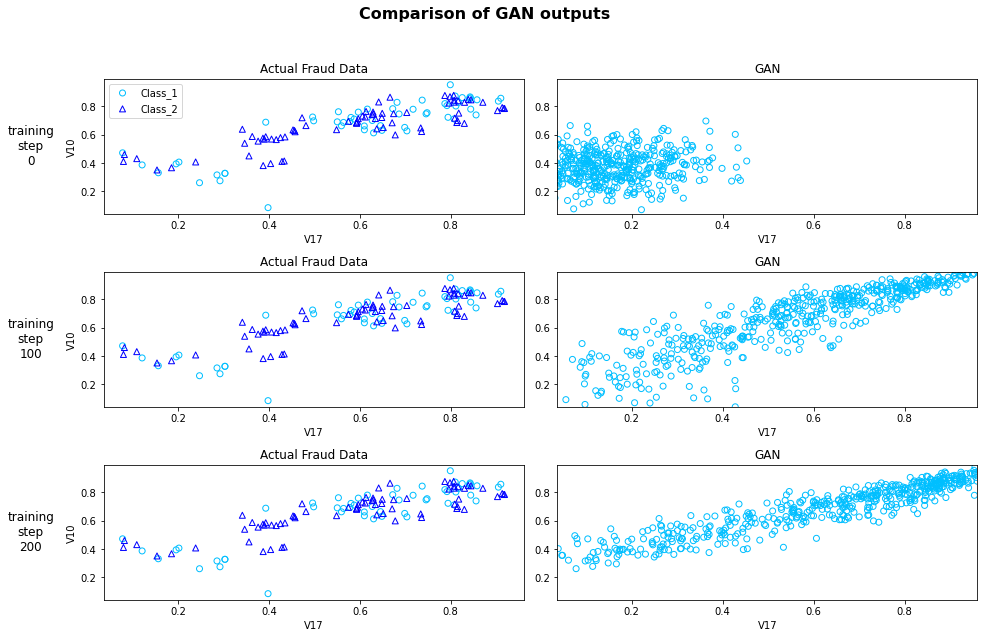

In [18]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real_processed = synthesizer.processor.transform(fraud_w_classes)
real_samples = synthesizer.get_data_batch(real_processed, batch_size)
class_labels = ['Class_1','Class_2']
real_samples = pd.DataFrame(real_samples, columns=num_cols+class_labels)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]],
                         label=label, marker=marker, edgecolors=color, facecolors='none' )

    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()

    if model_step_ix == 0:
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]],
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model(z)
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            gen_samples.to_csv('Generated_sample.csv')
            #write_csv(gen_samples, 'Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)